## Notebook for the creation of EVA the Data coach

Here is the final notebook, we are going to use all of our previous work, the data and the predictive model we build to create EVA, the autonomous Data coach.

In this notebook you will have all the versions of EVA, until the last one, the completed one, the final one. 

This final version is designed as an IA tool who can chat and discuss with the users but it can only rely on data and can coach only with the provide dataset and the models which it was trained on. Ultimately, the use of EVA capacity as an IA tool is only used as a purpose to discuss with the players and guide them thanks to the data she have access to.

Another important point, is that this project is made in collaboration with the creation and discord team of Chasingball, that said you need to know that we can only use the data that are in the dataset of Chasingball for the coaching. It is a free service to link the players account with the Chasingball database. It can only lead to improvements both for the dataset but also for EVA as more users will be able to use it and it will therefore upgrade !

## 1. Librairy import

In [1]:
import pandas as pd
import numpy as np
import os
import shap
from openai import OpenAI
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

## 2. Data loading & data manipulation

We need to load the CSV and do the manipulation by deleting the columns that we don't need, because they can spoil the outcome of the match and therefore our model will be incapacitated as it will not be able to predict and give advice.

In [ ]:
# Load the dataset

df = pd.read_csv("data/Final_Dataset_MVP.csv", sep=";")

# Manipulation of the dataset

target_col = "result"
df[target_col] = df[target_col].map({"winner": 1, "loser": 0})
cols_to_drop = ["goals", "goals conceded", "score", "goals conceded while last defender","shots","shooting percentage", "shots conceded"]
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])
X = df.select_dtypes(include=["number"])

## 3. Function and model implementation

In this part, we will implement the best predictive model that we created in a previous notebook, it was the funnel neural network.

We will also implement the SHAP function, which is the explainable model. It can explain what the predictive model predicted and we can use that to construct the coach as it will explain why someone lost and give them advice on what they can do to win and improve.

### 3.1. Implementation of the funnel predictive model

So we use the funnel neural network

In [3]:
# Creation of the train/test split

y = X[target_col]
X = X.drop(columns=[target_col])
feature_names = X.columns.tolist()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [4]:
# Implementation of the predictive model

model_entonnoir = Sequential([
    Dense(512, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.4),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.001)
model_entonnoir.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_entonnoir = model_entonnoir.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=300,
    batch_size=16,
    verbose=0
)

c:\Users\Yacine\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### 3.2. Implementation of SHAP

SHAP is an explainable tool that will search why the predictive model predicted that or that outcome by relying on the data. It will therefore explain the different outcomes. Ultimately it is a tool that we need, to make us understand why people loose, so we can use that to train our data coach.

In [5]:
# SHAP explainer
explainer = shap.KernelExplainer(
    model_entonnoir.predict,
    X_train[np.random.choice(X_train.shape[0], 100, replace=False)]
)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


## 4. EVA : First version

This version of EVA only relies on the use of the predictive model and SHAP. So it is not an autonomous model, but more a test to see if SHAP does work with the predictive model that I chose.

This version of EVA require the user to enter the index of the match they want the model to analyze, yes it is not optimal.

At the end, EVA will give the player the 3 features/statistics that he needs to work/improve on if he lost and if he wins she will give him 3 statistics that she found relatively weak in the player gamestyle. EVA will also give plots of the 3 best statistics of the player comparing them to the mean of those statistics in the winners gamestyle by also giving a plot for that.

### 4.1. Function creation for EVA

Creation of the function to test the coach.

In [6]:
# Function creation for EVA

def coaching_report(match_index):
    """
    Coaching intelligent pour un match donné.
    Explique le résultat avec SHAP + donne des conseils concrets.
    Retourne les plots et les informations pour EVA.
    """
    # Getting all the plays in the dataset
    
    x_match_orig = df.loc[match_index, feature_names].values.reshape(1, -1)
    x_match_scaled = scaler.transform(x_match_orig)
    y_real = df.loc[match_index, target_col]
    x_match_orig = scaler.inverse_transform(x_match_scaled)

    # The prediction of the model and the use of it
    
    y_pred_prob = model_entonnoir.predict(x_match_scaled)[0][0]
    y_pred_label = int(y_pred_prob > 0.5)

    # Use of SHAP explainer to use the data and explain the outcome

    explainer = shap.KernelExplainer(
        model_entonnoir.predict,
        X_train[:100]  
    )
    shap_values = explainer.shap_values(x_match_scaled)
    if isinstance(shap_values, list):
        shap_values = shap_values[0]
    shap_values = shap_values.flatten()

    # The dataframe produced by SHAP

    shap_df = pd.DataFrame({
        "statistics": feature_names,
        "shap_value": shap_values,
        "value": x_match_orig.flatten()
    })
    shap_df["abs_shap"] = shap_df["shap_value"].abs()
    shap_df = shap_df.sort_values("abs_shap", ascending=False)

    # The top 3 best statistics of the player
    
    top3 = shap_df.head(3)
    print("\nTop 3 influential statistics:")
    for _, row in top3.iterrows():
        impact = "helps winning" if row["shap_value"] > 0 else "hurts winning"
        print(
            f"- {row['statistics']} | "
            f"value={row['value']:.2f} | "
            f"SHAP={row['shap_value']:.3f} → {impact}"
        )

    # Means for the winners in those statistics
    
    winners = df[df[target_col] == 1]
    winners_avg = winners[feature_names].mean()

    # Statistics to improve, coaching
    
    gap_df = pd.DataFrame({
        "statistics": feature_names,
        "player_value": x_match_orig.flatten(),
        "winner_avg": winners_avg.values
    })
    gap_df["gap"] = gap_df["winner_avg"] - gap_df["player_value"]
    gap_df = gap_df.sort_values("gap", ascending=False)
    improve_df = gap_df.head(3)

    print("\nTop 3 statistics to improve:")
    for _, row in improve_df.iterrows():
        print(
            f"- {row['statistics']} | "
            f"you={row['player_value']:.2f} | "
            f"winners avg={row['winner_avg']:.2f}"
        )

    # Statistics where the player perform very well

    strengths = shap_df[
        (shap_df["shap_value"] > 0) &
        (~shap_df["statistics"].isin(top3["statistics"]))
    ]["statistics"].tolist()
    print("\nOther strengths:", ", ".join(strengths))

    # The different plots

    # Plot 1 : SHAP top 3 for the player
    fig_player = plt.figure(figsize=(6,4))
    plt.bar(top3["statistics"], top3["value"], color="#FF6F00")
    plt.title("Your top 3 statistics")
    plt.ylabel("Value")
    plt.tight_layout()

    # Plot 2 : SHAP top 3, the mean of the winners
    fig_winners = plt.figure(figsize=(6,4))
    plt.bar(top3["statistics"], winners_avg[top3["statistics"]], color="#00FF9C")
    plt.title("Average top statistics among winners")
    plt.ylabel("Value")
    plt.tight_layout()

    # Plot 3 : Statistics to improve for the player
    fig_improve = plt.figure(figsize=(6,4))
    plt.bar(improve_df["statistics"], improve_df["player_value"], color="#FF6F00")
    plt.title("Your weakest statistics in this match")
    plt.ylabel("Value")
    plt.tight_layout()

    # Plot 4 : Statistics to improve for the player, the mean of those by the winners
    fig_improve_winners = plt.figure(figsize=(6,4))
    plt.bar(improve_df["statistics"], improve_df["winner_avg"], color="#00FF9C")
    plt.title("Average winners on these statistics")
    plt.ylabel("Value")
    plt.tight_layout()

    # Return for EVA
    
    return {
        "prediction": {
            "predicted": "Win" if y_pred_label == 1 else "Loss",
            "probability": float(y_pred_prob),
            "real": "Win" if y_real == 1 else "Loss"
        },
        "top_statistics": top3.to_dict(orient="records"),
        "to_improve": improve_df, 
        "strengths": strengths,     
        "fig_player": fig_player,
        "fig_winners": fig_winners,
        "fig_improve": fig_improve,
        "fig_improve_winners": fig_improve_winners
    }

Now we have the function ready, we need to see if this first version of the coach works as it will tell us that all of ours tools are working.

### 4.2. Creation of the class of EVA

Now we will create the Instance of EVA the data coach by creating a class.

In [7]:
# Class creation

class EVA:
    """
    EVA : coach interactif basé sur le coaching_report + SHAP.
    """
    
# Initialization

    def __init__(self, df, feature_names, target_col):
        self.df = df
        self.feature_names = feature_names
        self.target_col = target_col

        self.last_report = None
        self.chat_history = []

# Function that analyze a play

    def analyze_match(self, match_index_df):
        """
        match_index_df : index du DataFrame original 
        """
        if match_index_df not in self.df.index:
            print(f"Match index {match_index_df} not found in DataFrame.")
            return
        report = coaching_report(match_index_df)
        self.last_report = report

# Printing of the result

        print(self._format_feedback(report))
        report["fig_player"].show()
        report["fig_winners"].show()
        report["fig_improve"].show()
        report["fig_improve_winners"].show()

# Function to deal with the feedbacks

    def _format_feedback(self, report):
        """
        Transforme le dictionnaire de coaching en texte lisible.
        """
        text = []
        p = report["prediction"]
        text.append(
            f"Match analysis complete.\n"
            f"Prediction: {p['predicted']} (prob {p['probability']:.2f})\n"
            f"Actual result: {p['real']}\n"
        )
        text.append("Top 3 statistics influencing this match:")
        for f in report["top_statistics"]:
            effect = "positive" if f["shap_value"] > 0 else "negative"
            text.append(
                f"- {f['statistics']} ({effect}, SHAP={f['shap_value']:.3f})"
            )

        if not report["to_improve"].empty:
            text.append("\nTop 3 statistics to improve:")
            for _, row in report["to_improve"].iterrows():
                text.append(
                    f"- {row['statistics']} | you={row['player_value']:.2f} | "
                    f"winners avg={row['winner_avg']:.2f}"
                )

        if report["strengths"]:
            text.append("\nOther strengths: " + ", ".join(report["strengths"]))

        return "\n".join(text)

# Function to communicate with EVA

    def chat(self, query):
        """
        Interaction type LLM (rule-based pour l’instant).
        """
        if self.last_report is None:
            return "No match analyzed yet. Use analyze_match(index) first."

        query_lower = query.lower()

        if "improve" in query_lower:
            df = self.last_report["to_improve"]
            if df.empty:
                return "No major improvements needed in this match."
            return (
                "You should focus on improving:\n" +
                "\n".join(
                    f"- {row['statistics']} (you={row['player_value']:.2f}, "
                    f"winners={row['winner_avg']:.2f})"
                    for _, row in df.iterrows()
                )
            )

        if "strength" in query_lower:
            strengths = self.last_report["strengths"]
            return (
                "Your strengths in this match:\n" + ", ".join(strengths)
                if strengths else
                "No clear strengths identified."
            )

        if "prediction" in query_lower or "result" in query_lower:
            p = self.last_report["prediction"]
            return (
                f"Predicted: {p['predicted']} (prob={p['probability']:.2f}) | "
                f"Actual: {p['real']}"
            )

        return (
            "You can ask me about:\n"
            "- What you should improve\n"
            "- Your strengths\n"
            "- The prediction vs actual result"
        )

We created the class of EVA that will tell how the Coach will work in this first version.

### 4.3. Test and result

Now, let's test this first version of EVA and see if it works.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


c:\Users\Yacine\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
6763/6763 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step

Top 3 influential statistics:
- demos inflicted | value=3.00 | SHAP=0.126 → helps winning
- count powerslide | value=74.00 | SHAP=0.105 → helps winning
- avg boost amount | value=36.37 | SHAP=0.094 → helps winning

Top 3 statistics to improve:
- amount overfill total | you=217.00 | winners avg=399.28
- avg distance to ball no possession | you=1821.00 | winners avg=1999.79
- avg distance to ball | you=1618.00 | winners avg=1719.72

Other strengths: avg distance to ball, amount used while supersonic, time offensive half, amount collected small pads, percentage in front of ball, avg distance to ball has possession, percentage offensive half
Match analysis complete.
Prediction: Win (prob 1.00)
Actual result: Loss

Top 3 statistics influencing this match:
- demos inflicted (positive, SHAP=0.126)
- count powerslide (positive, SHAP=0.105)
- avg boost amount (positive, SHAP=0.094)

Top 3 statistics to improve:
-

C:\Users\Yacine\AppData\Local\Temp\ipykernel_1048\1908194873.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  report["fig_player"].show()
C:\Users\Yacine\AppData\Local\Temp\ipykernel_1048\1908194873.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  report["fig_winners"].show()
C:\Users\Yacine\AppData\Local\Temp\ipykernel_1048\1908194873.py:35: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  report["fig_improve"].show()
C:\Users\Yacine\AppData\Local\Temp\ipykernel_1048\1908194873.py:36: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  report["fig_improve_winners"].show()


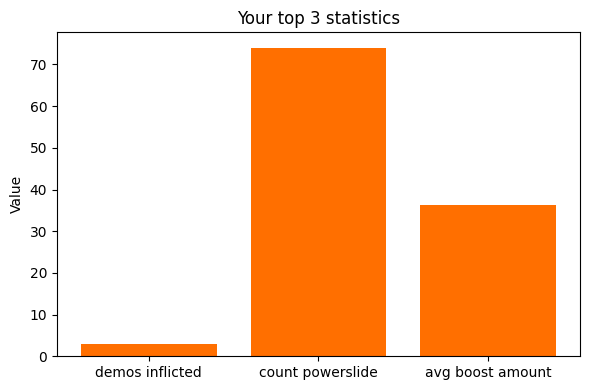

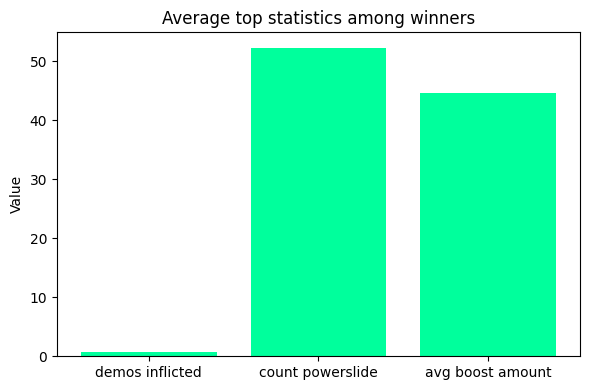

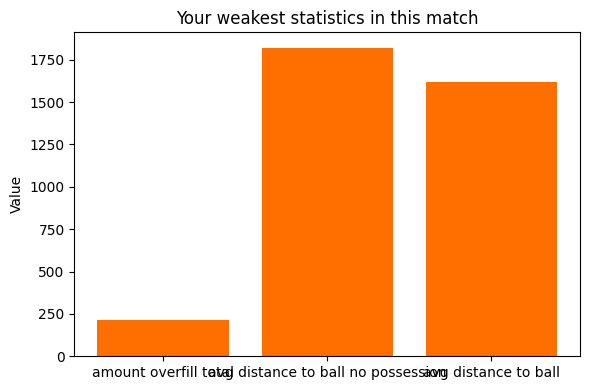

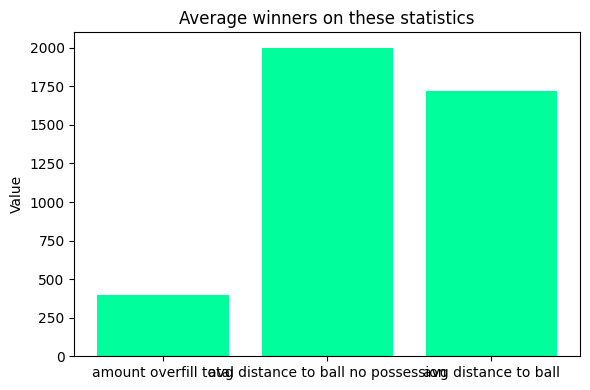

In [8]:
eva = EVA(
    df=df,
    feature_names=feature_names,
    target_col=target_col
)

# Here we choose the number of the play we want EVA to analyze
eva.analyze_match(1)

print(eva.chat("What should I improve?"))
print(eva.chat("What are my strengths?"))
print(eva.chat("prediction"))

So this first version of EVA can give us the statistics that she advices us to improve if we want to win, she also give us the statistics which we need to still work on if we won. She also tells us what are the other statistics in which we performed well and she also gives us the plots of those statistics and also the plots of the means of the winners in those statistics.

But even if it is a good start, it is not a Data interactive coach as she stills don't gives us advices and she needs us to enter a number, which is a bit confusing if we don't know where our games are located within the dataset.

But it allowed us to see that SHAP and our predictive model are working and they can be used for the coach.

## 5. EVA : Second version

Now that we know that all our tools are working, we can advance and improve EVA by trying other techniques.

In this second version of EVA, I wanted it to be more intuitive and more interactive. To do so, I changed the functioning of the coach. She still gives us the same output as the first versions with the plots and all, but the way to get to the play is different. Eva will firstly ask us what is our player name, after that she will get all the play of this player with their index, then we will give one of those index to EVA and she will analyze this play.

Therefore the use of the coach is more intuitive and more interactive.

But it is still not a fully fleshed data coach that we can talk to.

### 5.1. Creation of the interactive class of EVA

Now we will create the Instance of Interactive EVA the data coach by creating a class.

In [17]:
# CLass creation

class EVAInteractive:
    """
    EVAInteractive : mini LLM pour coach interactif.
    Permet de sélectionner un joueur, lister ses matchs,
    analyser un match avec SHAP et discuter des conseils.
    """
    
# Initialization

    def __init__(self, df, X_test, y_test, model, scaler, feature_names, target_col):
        self.df = df
        self.X_test = X_test
        self.y_test = y_test
        self.model = model
        self.scaler = scaler
        self.feature_names = feature_names
        self.target_col = target_col

        self.last_report = None
        self.chat_history = []
        self.selected_player = None
        self.player_matches = None
        
# Function to select the player

    def select_player(self, player_name_col, player_name):
        """
        Choisir un joueur et lister ses matchs.
        player_name_col : colonne contenant le nom des joueurs
        player_name : nom exact du joueur
        """
        self.selected_player = player_name
        self.player_matches = self.df[self.df[player_name_col] == player_name]

        if self.player_matches.empty:
            print(f"No matches found for {player_name}")
            return

        print(f"Found {len(self.player_matches)} matches for {player_name}:")
        for idx, row in self.player_matches.iterrows():
            print(f"- Index {idx}: result={row[self.target_col]}")

# Function to analyze the play

    def analyze_match(self, match_index):
        """
        Analyse un match choisi par son index.
        """
        if self.selected_player is None:
            print("Select a player first with select_player().")
            return

        report = coaching_report(match_index)
        self.last_report = report

        # Printing of the result
        print(self._format_feedback(report))
        report["fig_player"].show()
        report["fig_winners"].show()
        report["fig_improve"].show()
        report["fig_improve_winners"].show()

# Functions for the feedbacks of EVA

    def _format_feedback(self, report):
        """
        Transforme le dictionnaire de coaching en texte lisible.
        """
        text = []
        p = report["prediction"]
        text.append(
            f"Match analysis complete.\n"
            f"Prediction: {p['predicted']} (prob {p['probability']:.2f})\n"
            f"Actual result: {p['real']}\n"
        )

        text.append("Top 3 statistics influencing this match:")
        for f in report["top_statistics"]:
            effect = "positive" if f["shap_value"] > 0 else "negative"
            text.append(f"- {f['statistics']} ({effect}, impact {f['shap_value']:.3f})")

        if not report["to_improve"].empty:
            text.append("\nTop 3 statistics to improve:")
            for _, row in report["to_improve"].iterrows():
                text.append(
                    f"- {row['statistics']} | you={row['player_value']:.2f} | "
                    f"winners avg={row['winner_avg']:.2f}"
                )

        if report["strengths"]:
            text.append("\nOther strengths: " + ", ".join(report["strengths"]))

        return "\n".join(text)
    
# Function to discuss with EVA

    def chat(self, query):
        """
        Mini interaction type LLM.
        """
        if self.last_report is None:
            return "No match analyzed yet. Use analyze_match(index) first."

        query_lower = query.lower()
        response = ""

        if "improve" in query_lower:
            df = self.last_report["to_improve"]
            if df.empty:
                response = "No major improvements needed in this match!"
            else:
                lines = []
                for _, row in df.iterrows():
                    lines.append(
                        f"- {row['statistics']}: your value={row['player_value']:.2f}, "
                        f"average winners={row['winner_avg']:.2f}"
                    )
                response = "You should focus on improving these statistics:\n" + "\n".join(lines)

        elif "strength" in query_lower:
            strengths = self.last_report["strengths"]
            if not strengths:
                response = "No specific strengths identified in this match."
            else:
                response = "Your strong points in this match:\n" + ", ".join(strengths)

        elif "prediction" in query_lower or "result" in query_lower:
            p = self.last_report["prediction"]
            response = (
                f"The predicted result was {p['predicted']} "
                f"(prob={p['probability']:.2f}), actual result: {p['real']}"
            )

        else:
            response = (
                "I can provide insights on:\n"
                "- What you should improve\n"
                "- Your strengths\n"
                "- The predicted vs actual result\n"
                "Ask me about these!"
            )

        self.chat_history.append({"query": query, "response": response})
        return response

Now we have the class of the interactive EVA, normally it will asks us question.

### 5.2. Test and result

Now let's test the second version of EVA.

In [18]:
# Initialization of EVAInteractive

eva = EVAInteractive(
    df=df,
    X_test=X_test,
    y_test=y_test,
    model=model_entonnoir,
    scaler=scaler,
    feature_names=feature_names,
    target_col=target_col
)

In [19]:
# The first step is to enter your player name

eva.select_player(player_name_col="player name", player_name="Flowsen") # <-- Just here (took the example of a player)

Found 9 matches for Flowsen:
- Index 1: result=0
- Index 141: result=1
- Index 151: result=1
- Index 187: result=0
- Index 212: result=0
- Index 258: result=0
- Index 430: result=0
- Index 470: result=1
- Index 559: result=1


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


c:\Users\Yacine\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
6763/6763 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step

Top 3 influential statistics:
- avg distance to ball has possession | value=1701.00 | SHAP=0.186 → helps winning
- percentage in front of ball | value=22.09 | SHAP=0.109 → helps winning
- percentage behind ball | value=77.91 | SHAP=0.104 → helps winning

Top 3 statistics to improve:
- avg distance to ball no possession | you=1629.00 | winners avg=1999.79
- amount used while supersonic | you=174.00 | winners avg=266.32
- amount overfill total | you=311.00 | winners avg=399.28

Other strengths: avg distance to ball, avg speed, car id, time in front of ball, amount stolen small pads
Match analysis complete.
Prediction: Win (prob 1.00)
Actual result: Win

Top 3 statistics influencing this match:
- avg distance to ball has possession (positive, impact 0.186)
- percentage in front of ball (positive, impact 0.109)
- percentage behind ball (positive, impact 0.104)

Top 3 statistics to improve:
- avg distance to 

C:\Users\Yacine\AppData\Local\Temp\ipykernel_1048\3612167790.py:60: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  report["fig_player"].show()
C:\Users\Yacine\AppData\Local\Temp\ipykernel_1048\3612167790.py:61: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  report["fig_winners"].show()
C:\Users\Yacine\AppData\Local\Temp\ipykernel_1048\3612167790.py:62: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  report["fig_improve"].show()
C:\Users\Yacine\AppData\Local\Temp\ipykernel_1048\3612167790.py:63: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  report["fig_improve_winners"].show()


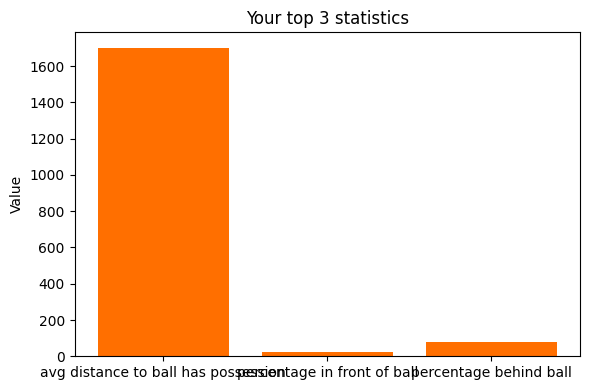

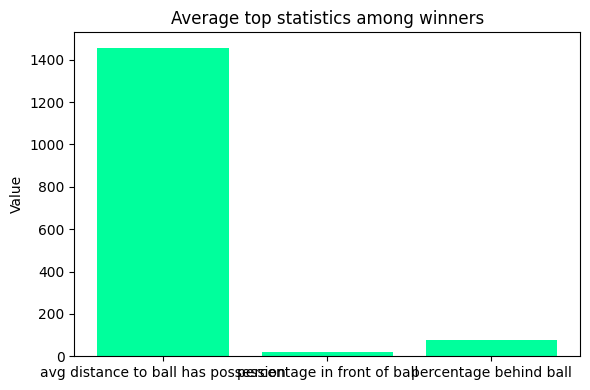

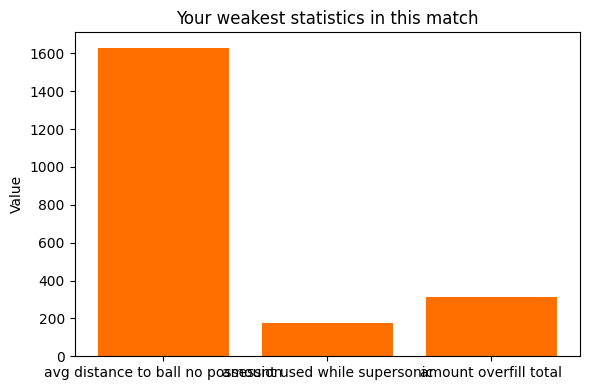

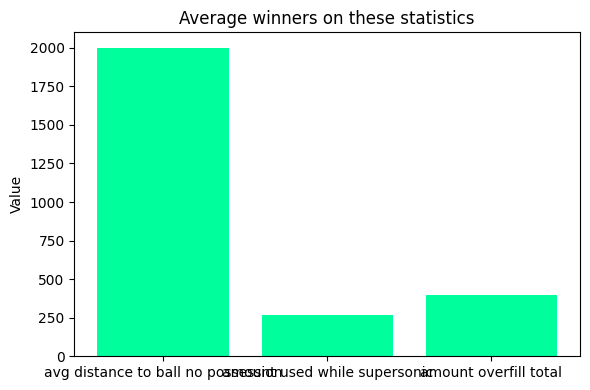

In [20]:
# Step two is to choose an index of one of our play and then EVA will analyze it

eva.analyze_match(match_index=559)# <-- Just here
print(eva.chat("What should I improve?"))
print(eva.chat("What are my strengths?"))
print(eva.chat("prediction"))

At the end, EVA does work and her use is more intuitive. But we haven't change the result of the coaching as she stills give the same results as the first version of EVA.

We still have one problem, EVA is still not an autonomous Data coach, she can not talk about the results with the players, we need to implement some "intelligence" in her.

## 6. EVA : Last version

Now, in this version, EVA will be completed and she will become a fully fleshed Data coach for Rocket League. So we have the core functions of the coach that are working and we built the interactivity with the coach. We also made EVA more intuitive by creating how people will interact with her and get their coaching.

The only thing she misses is the ability to chat with the players and answering their questions depending on their coaching.

To do so, we merged EVA with an API key of OPEN AI, but this is only used to make EVA able to discuss and chat, she will not give advice and analyze based on other things, she will only rely on the dataset we gave her and the model that are at her core. In the end, EVA is a mixed of those both techniques an LLM used for talking and an explainable model used to explain prediction, the fusion of those two things allowed the creation of a Data coach.

Now let's start creating the final version of EVA.

### 6.1. Prompt of the system

Firstly we need a prompt to make EVA understand her job and her limits. And this is a strong prompt that will guide her without restraining her.

In [21]:
SYSTEM_PROMPT = """
You are EVA, an AI esports performance coach.

RULES:
- You ONLY use the structured data provided.
- You NEVER invent statistics.
- You NEVER hallucinate features.
- If information is missing, say so clearly.
- You speak clearly, like a human coach.
- You give constructive, actionable advice.

You receive:
- Match prediction
- Top SHAP features
- Features to improve vs winners
- Player strengths

Your goal:
- Explain WHY the match was won or lost
- Give concrete advice
- Answer follow-up questions consistently
"""


### 6.2. Class creation for the final EVA

Now we will create the Instance of the final EVA the data coach by creating a class.

In [22]:
# Class creation

class EVA:
    """
    EVA v2 — Coach intelligent conversationnel
    Basé sur SHAP + Funnel NN + OpenAI
    """
    
# Initialization

    def __init__(self, df, feature_names, target_col, scaler):
        self.df = df
        self.client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
        self.feature_names = feature_names
        self.target_col = target_col
        self.scaler = scaler
        self.last_report = None
        self.player_name = None
        self.available_matches = []

# Function to select the player

    def select_player(self, player_name):
        self.player_name = player_name
        matches = self.df[self.df["player name"] == player_name]

        if matches.empty:
            print("No matches found for this player.")
            return []

        self.available_matches = matches.index.tolist()

        print(f"Found {len(self.available_matches)} matches for {player_name}:")
        for idx in self.available_matches:
            res = self.df.loc[idx, self.target_col]
            print(f"- Index {idx} | Result: {'Win' if res==1 else 'Loss'}")

        return self.available_matches

# Function to analyze the play

    def analyze_match(self, match_index):
        if match_index not in self.available_matches:
            print("Invalid match index. Select one from the list.")
            return

        report = coaching_report(match_index)
        self.last_report = report

        print("\n--- MATCH ANALYSIS ---")
        print(self._format_feedback(report))

        report["fig_player"].show()
        report["fig_winners"].show()
        report["fig_improve"].show()
        report["fig_improve_winners"].show()

    # Function for the prompting 
    
    def _build_prompt(self, user_question):
        r = self.last_report

        improve_txt = "\n".join(
            f"- {row['statistics']}: you={row['player_value']:.2f}, winners avg={row['winner_avg']:.2f}"
            for _, row in r["to_improve"].iterrows()
        )

        strengths_txt = ", ".join(r["strengths"])

        return f"""
You are EVA, an expert Rocket League coach.

MATCH CONTEXT:
Prediction: {r['prediction']['predicted']} (prob {r['prediction']['probability']:.2f})
Actual result: {r['prediction']['real']}

TOP FEATURES TO IMPROVE:
{improve_txt}

PLAYER STRENGTHS:
{strengths_txt}

TASK:
Answer the player's question like a professional coach.
Be concrete, encouraging, and tactical.
Do NOT invent statistics.

PLAYER QUESTION:
{user_question}
"""

# Function to discuss with EVA

    def chat(self, question):
        if self.last_report is None:
            return "Analyze a match first."

        prompt = self._build_prompt(question)

        response = self.client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "You are a professional esports coach."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.4
        )

        return response.choices[0].message.content

# Function for feedbacks for EVA

    def _format_feedback(self, report):
        p = report["prediction"]
        return (
            f"Prediction: {p['predicted']} (prob {p['probability']:.2f})\n"
            f"Actual result: {p['real']}"
        )

Now we have created the final class for EVA.

### 6.3. Test and result

Now let's test the final version of EVA.

In [23]:
# The first step is to select the player name

eva = EVA(df, feature_names, target_col, scaler)
eva.select_player("Flowsen")# <-- Just here (took the example of a player)


Found 9 matches for Flowsen:
- Index 1 | Result: Loss
- Index 141 | Result: Win
- Index 151 | Result: Win
- Index 187 | Result: Loss
- Index 212 | Result: Loss
- Index 258 | Result: Loss
- Index 430 | Result: Loss
- Index 470 | Result: Win
- Index 559 | Result: Win


[1, 141, 151, 187, 212, 258, 430, 470, 559]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

c:\Users\Yacine\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
6763/6763 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step

Top 3 influential statistics:
- avg distance to ball has possession | value=1701.00 | SHAP=0.182 → helps winning
- percentage behind ball | value=77.91 | SHAP=0.111 → helps winning
- percentage in front of ball | value=22.09 | SHAP=0.102 → helps winning

Top 3 statistics to improve:
- avg distance to ball no possession | you=1629.00 | winners avg=1999.79
- amount used while supersonic | you=174.00 | winners avg=266.32
- amount overfill total | you=311.00 | winners avg=399.28

Other strengths: avg distance to ball, car id, avg speed, time in front of ball, count stolen small pads

--- MATCH ANALYSIS ---
Prediction: Win (prob 1.00)
Actual result: Win


C:\Users\Yacine\AppData\Local\Temp\ipykernel_1048\396198663.py:53: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  report["fig_player"].show()
C:\Users\Yacine\AppData\Local\Temp\ipykernel_1048\396198663.py:54: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  report["fig_winners"].show()
C:\Users\Yacine\AppData\Local\Temp\ipykernel_1048\396198663.py:55: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  report["fig_improve"].show()
C:\Users\Yacine\AppData\Local\Temp\ipykernel_1048\396198663.py:56: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  report["fig_improve_winners"].show()


First off, congratulations on the win! It's important to celebrate victories, even when there are areas to improve. 

Now, regarding your question about why you might have felt you lost the match despite the win, let’s break down some key areas where you can enhance your gameplay.

1. **Average Distance to Ball (No Possession)**: Your average distance to the ball without possession was 1629.00, while the winners averaged 1999.79. This suggests that you might have been too close to the ball at times, which can limit your options for plays and positioning. Try to focus on maintaining a greater distance when you don't have possession. This will allow you to read the game better and react more effectively to plays developing around you.

2. **Supersonic Boost Usage**: You used 174.00 units of boost while supersonic, compared to the winners' average of 266.32. This indicates that you might not have been utilizing your boost effectively when you were at high speed. Make sure to optimize your

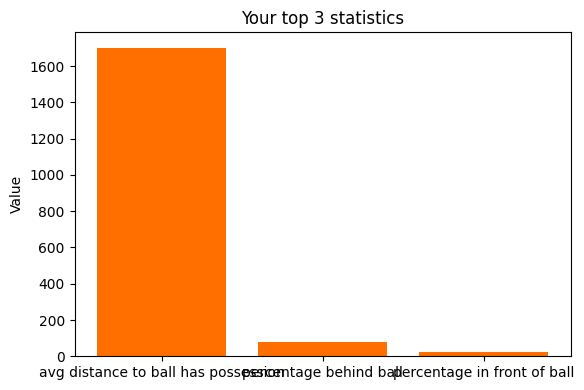

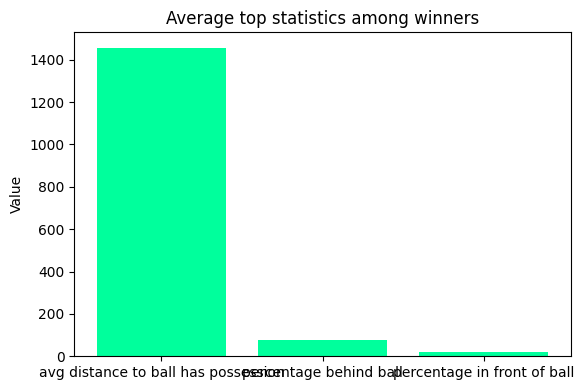

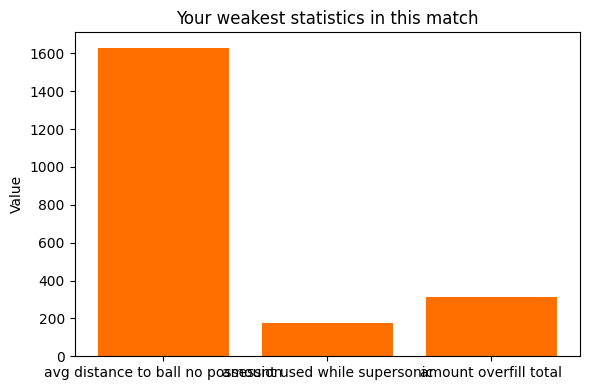

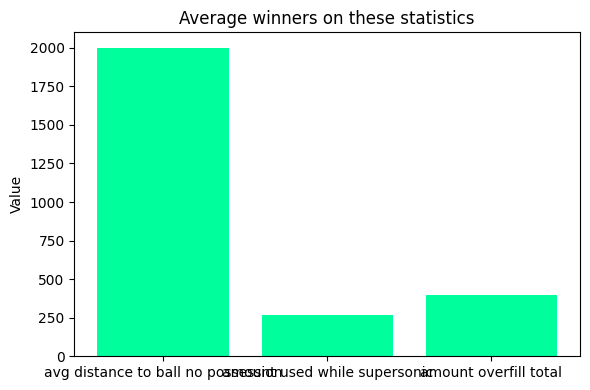

In [24]:
# The second step is to enter the index of one play of the player

eva.analyze_match(559)# <-- Just here 
print(eva.chat("Why did I lose this match?"))
print(eva.chat("What should I focus on next games?"))
print(eva.chat("Explain this like a real coach"))

At the end, this final version of EVA does work. It gives us feedbacks about our games with statistics to improve and comparing with other players, plots but also coaching. As now we can ask her question and chat with her as it is a Data Coach.

EVA is therefore a mix of an LLM used to interact with people, but with only the capacity to use the dataset provided and and the core functions that allow it to work. We need to remember that the coach only work for players that are in the dataset.

This final version of EVA is the Data coach that I wanted to create and now we just need to put it a website so everyone can use it.